In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

df = pd.read_csv('~/Desktop/self_model_data/df_grouped_self.csv')
df_test_hidden = pd.read_csv('~/Desktop/self_model_data/test_self_sentiment.csv')
df_validation_hidden = pd.read_csv('~/Desktop/self_model_data/validation_self_sentiment.csv')

In [3]:
df = df.drop(columns=[
    "like_count", 
    "tomatometer_status", 
    "tomatometer_rating", 
    "audience_status", 
    "audience_rating", 
    "content_rating", 
    "production_company",
    "reviews",
    "review_lemmatized"
    ])
df

,tconst,numVotes,self_sentiment,movie_title,year,genre,label
0,tt0016029,1646.0,3.50,the little colonel,1935,Unknown,True
1,tt0017961,1080.0,3.25,happiness,1935,Unknown,True
2,tt0020298,3226.0,3.00,queen kelly,1932,Unknown,True
3,tt0020768,3199.0,3.75,city girl,1930,Unknown,True
4,tt0021309,0.0,3.25,the story of the fox,1937,Unknown,True
...,...,...,...,...,...,...,...
7807,tt9850344,1325.0,3.00,night shift,2020,Unknown,False
7808,tt9850386,4144.0,3.50,the bee gees: how can you mend a broken heart,2020,Unknown,True
7809,tt9900782,0.0,3.50,kaithi,2019,Unknown,True
7810,tt9904802,0.0,2.75,enemy lines,2020,Unknown,False


In [5]:
splits = {'train': 'train.csv', 'validation': 'validation.csv', 'test': 'test.csv'}
genres = pd.read_csv("hf://datasets/jquigl/imdb-genres/" + splits["train"])
genres.head()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: b95adfd1-2c6a-4f11-9de1-c15fd2e5f0d0)')' thrown while requesting GET https://huggingface.co/datasets/jquigl/imdb-genres/resolve/main/train.csv
Retrying in 1s [Retry 1/5].


,movie title - year,genre,expanded-genres,rating,description
0,Flaming Ears - 1992,Fantasy,"Fantasy, Sci-Fi",6.0,Flaming Ears is a pop sci-fi lesbian fantasy f...
1,Jeg elsker dig - 1957,Romance,"Comedy, Drama, Romance",5.8,Six people - three couples - meet at random at...
2,Povjerenje - 2021,Thriller,Thriller,NaN,"In a small unnamed town, in year 2025, Krsto w..."
3,Gulliver Returns - 2021,Fantasy,"Animation, Adventure, Family",4.4,The legendary Gulliver returns to the Kingdom ...
4,Prithvi Vallabh - 1924,Biography,"Biography, Drama, Romance",NaN,"Seminal silent historical film, the story feat..."


In [7]:
# genres = genres.drop(columns=['expanded-genres', 'rating', 'description'])

# genres[['movie_title', 'year']] = genres['movie title - year'].str.extract(r'^(.+)\s*-\s*(\d{4})$')
genres['movie_title'] = genres['movie title - year'].str.split(' - ', n=1).str[0]
#genres = genres.dropna(subset=['year'])  # Remove rows where extraction failed
#genres['year'] = genres['year'].astype(int)
genres["movie_title"] = genres["movie_title"].str.lower()

genres

,movie title - year,genre,expanded-genres,rating,description,movie_title
0,Flaming Ears - 1992,Fantasy,"Fantasy, Sci-Fi",6.0,Flaming Ears is a pop sci-fi lesbian fantasy f...,flaming ears
1,Jeg elsker dig - 1957,Romance,"Comedy, Drama, Romance",5.8,Six people - three couples - meet at random at...,jeg elsker dig
2,Povjerenje - 2021,Thriller,Thriller,NaN,"In a small unnamed town, in year 2025, Krsto w...",povjerenje
3,Gulliver Returns - 2021,Fantasy,"Animation, Adventure, Family",4.4,The legendary Gulliver returns to the Kingdom ...,gulliver returns
4,Prithvi Vallabh - 1924,Biography,"Biography, Drama, Romance",NaN,"Seminal silent historical film, the story feat...",prithvi vallabh
...,...,...,...,...,...,...
238251,Kaalapani - 1996,History,"Action, Drama, History",8.5,"Govardhan, a doctor by profession, is wrongly ...",kaalapani
238252,The Set-Up - 2014,Action,"Action, Comedy, Romance",5.8,Kat Zelig's blind date is interrupted by terro...,the set-up
238253,Der Bucklige von Soho - 1966,Horror,"Crime, Horror, Thriller",5.8,A woman is kidnapped and her identity is stole...,der bucklige von soho
238254,The Shadow Thing - nan,Horror,Horror,NaN,The Phantom and Persephone.,the shadow thing


In [10]:
genres = genres.drop(columns=["movie title - year", "expanded-genres", "rating", "description"])

In [11]:
merged_df = pd.merge(genres, df, on=['movie_title'], how='right')

In [12]:
merged_df["genre_x"].value_counts()

genre_x
Thriller     3088
Romance      2005
Action       1894
Horror       1860
Crime        1627
Mystery      1033
Adventure    1009
Scifi         877
Fantasy       818
Family        642
War           386
Biography     355
History       280
Animation     255
Sports        184
Film-noir     100
Name: count, dtype: int64

In [13]:
merged_df["genre"] = merged_df["genre_x"]
merged_df = merged_df.drop(columns=["genre_x", "genre_y"])
merged_df

,movie_title,tconst,numVotes,self_sentiment,year,label,genre
0,the little colonel,tt0016029,1646.0,3.50,1935,True,Romance
1,the little colonel,tt0016029,1646.0,3.50,1935,True,Family
2,happiness,tt0017961,1080.0,3.25,1935,True,Action
3,queen kelly,tt0020298,3226.0,3.00,1932,True,NaN
4,city girl,tt0020768,3199.0,3.75,1930,True,NaN
...,...,...,...,...,...,...,...
18617,kaithi,tt9900782,0.0,3.50,2019,True,Crime
18618,kaithi,tt9900782,0.0,3.50,2019,True,Adventure
18619,kaithi,tt9900782,0.0,3.50,2019,True,Action
18620,enemy lines,tt9904802,0.0,2.75,2020,False,War


In [15]:
# Frequency encoding for genres
genre_freq = merged_df['genre'].value_counts()  # Get frequency of each genre
merged_df['genre_encoded'] = merged_df['genre'].map(genre_freq).fillna(0)

In [16]:
merged_df

,movie_title,tconst,numVotes,self_sentiment,year,label,genre,genre_encoded
0,the little colonel,tt0016029,1646.0,3.50,1935,True,Romance,2005.0
1,the little colonel,tt0016029,1646.0,3.50,1935,True,Family,642.0
2,happiness,tt0017961,1080.0,3.25,1935,True,Action,1894.0
3,queen kelly,tt0020298,3226.0,3.00,1932,True,NaN,0.0
4,city girl,tt0020768,3199.0,3.75,1930,True,NaN,0.0
...,...,...,...,...,...,...,...,...
18617,kaithi,tt9900782,0.0,3.50,2019,True,Crime,1627.0
18618,kaithi,tt9900782,0.0,3.50,2019,True,Adventure,1009.0
18619,kaithi,tt9900782,0.0,3.50,2019,True,Action,1894.0
18620,enemy lines,tt9904802,0.0,2.75,2020,False,War,386.0


In [17]:
writing = pd.read_json("~/Desktop/writing.json")
directors = pd.read_json("~/Desktop/directing.json")

In [18]:
df_writers_grouped = (
    writing
    .groupby('movie')['writer']
    .apply(list)
    .reset_index(name='writers')
)

df_directors_grouped = (
    directors
    .groupby('movie')['director']
    .apply(list)
    .reset_index(name='directors')
)

print(df_writers_grouped)
df_directors_grouped

          movie                                       writers
0     tt0003740  [nm0195339, nm0515385, nm0665163, nm0758215]
1     tt0008663             [nm0406585, nm0596410, nm0803705]
2     tt0009369                        [nm0215874, nm0370271]
3     tt0010307                                   [nm0304098]
4     tt0010600  [nm0006782, nm0473134, nm0523932, nm0932559]
...         ...                                           ...
9995  tt9850344             [nm3124777, nm1987983, nm0284774]
9996  tt9850386                                   [nm0598531]
9997  tt9900782                        [nm7992231, nm7807469]
9998  tt9904802                        [nm0942647, nm3853396]
9999  tt9911196             [nm2063122, nm0277932, nm3547655]

[10000 rows x 2 columns]


,movie,directors
0,tt0003740,[nm0665163]
1,tt0008663,[nm0803705]
2,tt0009369,"[nm0428059, nm0949648]"
3,tt0010307,[nm0304098]
4,tt0010600,[nm0523932]
...,...,...
9995,tt9850344,[nm0284774]
9996,tt9850386,[nm0550881]
9997,tt9900782,[nm7992231]
9998,tt9904802,[nm0052054]


In [19]:
df_writers_directors = pd.merge(df_writers_grouped, 
                                df_directors_grouped, 
                                on='movie', 
                                how='outer')

df_writers_directors

,movie,writers,directors
0,tt0003740,"[nm0195339, nm0515385, nm0665163, nm0758215]",[nm0665163]
1,tt0008663,"[nm0406585, nm0596410, nm0803705]",[nm0803705]
2,tt0009369,"[nm0215874, nm0370271]","[nm0428059, nm0949648]"
3,tt0010307,[nm0304098],[nm0304098]
4,tt0010600,"[nm0006782, nm0473134, nm0523932, nm0932559]",[nm0523932]
...,...,...,...
9995,tt9850344,"[nm3124777, nm1987983, nm0284774]",[nm0284774]
9996,tt9850386,[nm0598531],[nm0550881]
9997,tt9900782,"[nm7992231, nm7807469]",[nm7992231]
9998,tt9904802,"[nm0942647, nm3853396]",[nm0052054]


In [20]:
df_train = pd.merge(merged_df, df_writers_directors, left_on="tconst", right_on='movie', how='left')
df_train = df_train.drop(columns="movie")
df_train

,movie_title,tconst,numVotes,self_sentiment,year,label,genre,genre_encoded,writers,directors
0,the little colonel,tt0016029,1646.0,3.50,1935,True,Romance,2005.0,"[nm0175902, nm0426531, nm0124877]",[nm0124877]
1,the little colonel,tt0016029,1646.0,3.50,1935,True,Family,642.0,"[nm0175902, nm0426531, nm0124877]",[nm0124877]
2,happiness,tt0017961,1080.0,3.25,1935,True,Action,1894.0,[nm0575963],[nm0575963]
3,queen kelly,tt0020298,3226.0,3.00,1932,True,NaN,0.0,"[nm0002233, nm0014703, nm0322227]","[nm0002233, nm0092915]"
4,city girl,tt0020768,3199.0,3.75,1930,True,NaN,0.0,"[nm0504443, nm0896826, nm0651000, nm0129721, n...",[nm0003638]
...,...,...,...,...,...,...,...,...,...,...
18617,kaithi,tt9900782,0.0,3.50,2019,True,Crime,1627.0,"[nm7992231, nm7807469]",[nm7992231]
18618,kaithi,tt9900782,0.0,3.50,2019,True,Adventure,1009.0,"[nm7992231, nm7807469]",[nm7992231]
18619,kaithi,tt9900782,0.0,3.50,2019,True,Action,1894.0,"[nm7992231, nm7807469]",[nm7992231]
18620,enemy lines,tt9904802,0.0,2.75,2020,False,War,386.0,"[nm0942647, nm3853396]",[nm0052054]


In [22]:
df_train = (
    df_train.groupby('tconst')
      .agg({
          # For columns that are consistent within a single tconst, just take 'first'
          'movie_title': 'first',
          'numVotes': 'first',
          'self_sentiment': 'first',
          'label': 'first',
          'year': 'first',
          'genre': 'first',
          'genre_encoded': 'first',
          
          # For columns that are lists, combine them into a single list (removing duplicates)
          'writers': lambda col: list(set(x for sublist in col.dropna() for x in sublist)),
          'directors': lambda col: list(set(x for sublist in col.dropna() for x in sublist))
      })
      .reset_index()
)

df_train

,tconst,movie_title,numVotes,self_sentiment,label,year,genre,genre_encoded,writers,directors
0,tt0016029,the little colonel,1646.0,3.50,True,1935,Romance,2005.0,"[nm0175902, nm0124877, nm0426531]",[nm0124877]
1,tt0017961,happiness,1080.0,3.25,True,1935,Action,1894.0,[nm0575963],[nm0575963]
2,tt0020298,queen kelly,3226.0,3.00,True,1932,None,0.0,"[nm0322227, nm0014703, nm0002233]","[nm0002233, nm0092915]"
3,tt0020768,city girl,3199.0,3.75,True,1930,None,0.0,"[nm0129721, nm0651000, nm0385012, nm0504443, n...",[nm0003638]
4,tt0021309,the story of the fox,0.0,3.25,True,1937,Fantasy,818.0,"[nm0635163, nm0634113, nm0324473, nm0724858, n...","[nm0823088, nm0823089]"
...,...,...,...,...,...,...,...,...,...,...
7807,tt9850344,night shift,1325.0,3.00,False,2020,Crime,1627.0,"[nm3124777, nm1987983, nm0284774]",[nm0284774]
7808,tt9850386,the bee gees: how can you mend a broken heart,4144.0,3.50,True,2020,None,0.0,[nm0598531],[nm0550881]
7809,tt9900782,kaithi,0.0,3.50,True,2019,Thriller,3088.0,"[nm7992231, nm7807469]",[nm7992231]
7810,tt9904802,enemy lines,0.0,2.75,False,2020,War,386.0,"[nm3853396, nm0942647]",[nm0052054]


In [23]:
df_validation_hidden = df_validation_hidden.drop(columns=[
    "like_count", 
    "tomatometer_status", 
    "tomatometer_rating", 
    "audience_status", 
    "audience_rating", 
    "content_rating", 
    "production_company",
    "review",
    ])
df_test_hidden = df_test_hidden.drop(columns=[
    "like_count", 
    "tomatometer_status", 
    "tomatometer_rating", 
    "audience_status", 
    "audience_rating", 
    "content_rating", 
    "production_company",
    "review",
    ])

In [24]:
df_validation_hidden = pd.merge(genres, df_validation_hidden, on=['movie_title'], how='right')
df_test_hidden = pd.merge(genres, df_test_hidden, on=['movie_title'], how='right')

df_test_hidden

,genre_x,movie_title,year,tconst,numVotes,genre_y,self_sentiment
0,History,cabiria,1914,tt0003740,3452.0,Unknown,4
1,War,cabiria,1914,tt0003740,3452.0,Unknown,4
2,Adventure,cabiria,1914,tt0003740,3452.0,Unknown,4
3,NaN,a man there was,1917,tt0008663,1882.0,Unknown,4
4,War,j'accuse!,1919,tt0010307,1692.0,Unknown,4
...,...,...,...,...,...,...,...
2296,Thriller,hope,2019,tt9812614,1402.0,Unknown,4
2297,Action,hope,2019,tt9812614,1402.0,Unknown,4
2298,Mystery,hope,2019,tt9812614,1402.0,Unknown,4
2299,Romance,hope,2019,tt9812614,1402.0,Unknown,4


In [25]:
df_validation_hidden["genre"] = df_validation_hidden["genre_x"]
df_validation_hidden = df_validation_hidden.drop(columns=["genre_x", "genre_y"])

df_test_hidden["genre"] = df_test_hidden["genre_x"]
df_test_hidden = df_test_hidden.drop(columns=["genre_x", "genre_y"])
df_test_hidden

,movie_title,year,tconst,numVotes,self_sentiment,genre
0,cabiria,1914,tt0003740,3452.0,4,History
1,cabiria,1914,tt0003740,3452.0,4,War
2,cabiria,1914,tt0003740,3452.0,4,Adventure
3,a man there was,1917,tt0008663,1882.0,4,NaN
4,j'accuse!,1919,tt0010307,1692.0,4,War
...,...,...,...,...,...,...
2296,hope,2019,tt9812614,1402.0,4,Thriller
2297,hope,2019,tt9812614,1402.0,4,Action
2298,hope,2019,tt9812614,1402.0,4,Mystery
2299,hope,2019,tt9812614,1402.0,4,Romance


In [26]:
df_validation_hidden = pd.merge(df_validation_hidden, df_writers_directors, left_on="tconst", right_on='movie', how='left')
df_validation_hidden = df_validation_hidden.drop(columns="movie")

df_test_hidden = pd.merge(df_test_hidden, df_writers_directors, left_on="tconst", right_on='movie', how='left')
df_test_hidden = df_test_hidden.drop(columns="movie")
df_test_hidden

,movie_title,year,tconst,numVotes,self_sentiment,genre,writers,directors
0,cabiria,1914,tt0003740,3452.0,4,History,"[nm0195339, nm0515385, nm0665163, nm0758215]",[nm0665163]
1,cabiria,1914,tt0003740,3452.0,4,War,"[nm0195339, nm0515385, nm0665163, nm0758215]",[nm0665163]
2,cabiria,1914,tt0003740,3452.0,4,Adventure,"[nm0195339, nm0515385, nm0665163, nm0758215]",[nm0665163]
3,a man there was,1917,tt0008663,1882.0,4,NaN,"[nm0406585, nm0596410, nm0803705]",[nm0803705]
4,j'accuse!,1919,tt0010307,1692.0,4,War,[nm0304098],[nm0304098]
...,...,...,...,...,...,...,...,...
2296,hope,2019,tt9812614,1402.0,4,Thriller,[nm0845618],[nm0845618]
2297,hope,2019,tt9812614,1402.0,4,Action,[nm0845618],[nm0845618]
2298,hope,2019,tt9812614,1402.0,4,Mystery,[nm0845618],[nm0845618]
2299,hope,2019,tt9812614,1402.0,4,Romance,[nm0845618],[nm0845618]


In [27]:
df_validation_hidden['genre_encoded'] = df_validation_hidden['genre'].map(genre_freq).fillna(0)
df_test_hidden['genre_encoded'] = df_test_hidden['genre'].map(genre_freq).fillna(0)

In [29]:
df_validation_hidden = (
    df_validation_hidden.groupby('tconst')
      .agg({
          # For columns that are consistent within a single tconst, just take 'first'
          'movie_title': 'first',
          'numVotes': 'first',
          'self_sentiment': 'first',
          'year': 'first',
          'genre': 'first',
          'genre_encoded': 'first',
          
          # For columns that are lists, combine them into a single list (removing duplicates)
          'writers': lambda col: list(set(x for sublist in col.dropna() for x in sublist)),
          'directors': lambda col: list(set(x for sublist in col.dropna() for x in sublist))
      })
      .reset_index()
)

df_validation_hidden

,tconst,movie_title,numVotes,self_sentiment,year,genre,genre_encoded,writers,directors
0,tt0003740,cabiria,3452.0,4,1914,History,280.0,"[nm0195339, nm0515385, nm0665163, nm0758215]",[nm0665163]
1,tt0008663,a man there was,1882.0,4,1917,None,0.0,"[nm0406585, nm0596410, nm0803705]",[nm0803705]
2,tt0010307,j'accuse!,1692.0,4,1919,War,386.0,[nm0304098],[nm0304098]
3,tt0014429,safety last!,19898.0,3,1923,Action,1894.0,"[nm0369841, nm0730018, nm0853130, nm0516001, n...","[nm0628345, nm0853130]"
4,tt0015175,die nibelungen: siegfried,5676.0,4,1924,Adventure,1009.0,"[nm0902376, nm0000485]",[nm0000485]
...,...,...,...,...,...,...,...,...,...
950,tt9686154,you will die at 20,2106.0,4,2019,None,0.0,"[nm5617646, nm12933710, nm2691011]",[nm5617646]
951,tt9690328,paper spiders,0.0,4,2020,None,0.0,"[nm1630654, nm4363465]",[nm1630654]
952,tt9735790,me you madness,1056.0,1,2021,None,0.0,[nm2325602],[nm2325602]
953,tt9769668,tughlaq durbar,1430.0,3,2021,None,0.0,"[nm13058768, nm10470070]",[nm10470070]


In [30]:
df_test_hidden = (
    df_test_hidden.groupby('tconst')
      .agg({
          # For columns that are consistent within a single tconst, just take 'first'
          'movie_title': 'first',
          'numVotes': 'first',
          'self_sentiment': 'first',
          'year': 'first',
          'genre': 'first',
          'genre_encoded': 'first',
          
          # For columns that are lists, combine them into a single list (removing duplicates)
          'writers': lambda col: list(set(x for sublist in col.dropna() for x in sublist)),
          'directors': lambda col: list(set(x for sublist in col.dropna() for x in sublist))
      })
      .reset_index()
)

df_test_hidden

,tconst,movie_title,numVotes,self_sentiment,year,genre,genre_encoded,writers,directors
0,tt0003740,cabiria,3452.0,4,1914,History,280.0,"[nm0195339, nm0515385, nm0665163, nm0758215]",[nm0665163]
1,tt0008663,a man there was,1882.0,4,1917,None,0.0,"[nm0406585, nm0596410, nm0803705]",[nm0803705]
2,tt0010307,j'accuse!,1692.0,4,1919,War,386.0,[nm0304098],[nm0304098]
3,tt0014429,safety last!,19898.0,3,1923,Action,1894.0,"[nm0369841, nm0730018, nm0853130, nm0516001, n...","[nm0628345, nm0853130]"
4,tt0015175,die nibelungen: siegfried,5676.0,4,1924,Adventure,1009.0,"[nm0902376, nm0000485]",[nm0000485]
...,...,...,...,...,...,...,...,...,...
950,tt9686154,you will die at 20,2106.0,4,2019,None,0.0,"[nm5617646, nm12933710, nm2691011]",[nm5617646]
951,tt9690328,paper spiders,0.0,4,2020,None,0.0,"[nm1630654, nm4363465]",[nm1630654]
952,tt9735790,me you madness,1056.0,1,2021,None,0.0,[nm2325602],[nm2325602]
953,tt9769668,tughlaq durbar,1430.0,3,2021,None,0.0,"[nm13058768, nm10470070]",[nm10470070]


In [31]:
# instead of having a list of writers and directors, we can have the count of them for easier processing
writer_counts = df_train['writers'].astype(str).value_counts()
director_counts = df_train['directors'].astype(str).value_counts()

df_train['num_writers'] = df_train['writers'].astype(str).map(writer_counts)
df_train['num_directors'] = df_train['directors'].astype(str).map(director_counts)

In [33]:
df_validation_hidden['num_writers'] = df_validation_hidden['writers'].astype(str).map(df_validation_hidden['writers'].astype(str).value_counts())
df_validation_hidden['num_directors'] = df_validation_hidden['directors'].astype(str).map(df_validation_hidden['directors'].astype(str).value_counts())

df_test_hidden['num_writers'] = df_test_hidden['writers'].astype(str).map(df_test_hidden['writers'].astype(str).value_counts())
df_test_hidden['num_directors'] = df_test_hidden['directors'].astype(str).map(df_test_hidden['directors'].astype(str).value_counts())
df_test_hidden

,tconst,movie_title,numVotes,self_sentiment,year,genre,genre_encoded,writers,directors,num_writers,num_directors
0,tt0003740,cabiria,3452.0,4,1914,History,280.0,"[nm0195339, nm0515385, nm0665163, nm0758215]",[nm0665163],1,1
1,tt0008663,a man there was,1882.0,4,1917,None,0.0,"[nm0406585, nm0596410, nm0803705]",[nm0803705],1,1
2,tt0010307,j'accuse!,1692.0,4,1919,War,386.0,[nm0304098],[nm0304098],1,1
3,tt0014429,safety last!,19898.0,3,1923,Action,1894.0,"[nm0369841, nm0730018, nm0853130, nm0516001, n...","[nm0628345, nm0853130]",1,1
4,tt0015175,die nibelungen: siegfried,5676.0,4,1924,Adventure,1009.0,"[nm0902376, nm0000485]",[nm0000485],2,2
...,...,...,...,...,...,...,...,...,...,...,...
950,tt9686154,you will die at 20,2106.0,4,2019,None,0.0,"[nm5617646, nm12933710, nm2691011]",[nm5617646],1,1
951,tt9690328,paper spiders,0.0,4,2020,None,0.0,"[nm1630654, nm4363465]",[nm1630654],1,1
952,tt9735790,me you madness,1056.0,1,2021,None,0.0,[nm2325602],[nm2325602],1,1
953,tt9769668,tughlaq durbar,1430.0,3,2021,None,0.0,"[nm13058768, nm10470070]",[nm10470070],1,1


We can do the log of most of the values so there is not such a spike of different in most of the columns and avoid outliers that could make our predictions lower.
(we add the +1 cuz there will be 0s, that way we avoid either very small values or the point of -infinity)

In [34]:
df_train['log_numVotes'] = np.log1p(df_train['numVotes'])
df_validation_hidden['log_numVotes'] = np.log1p(df_validation_hidden['numVotes'])
df_test_hidden['log_numVotes'] = np.log1p(df_test_hidden['numVotes'])

In [35]:
df_train['log_numVotes'] = df_train['log_numVotes'].fillna(df_train['log_numVotes'].median())
df_validation_hidden['log_numVotes'] = df_validation_hidden['log_numVotes'].fillna(df_validation_hidden['log_numVotes'].median())
df_test_hidden['log_numVotes'] = df_test_hidden['log_numVotes'].fillna(df_test_hidden['log_numVotes'].median())

In [36]:
df_train['log_num_directors'] = np.log1p(df_train['num_directors'])
df_train['log_num_writers'] = np.log1p(df_train['num_writers'])
df_train['log_genre_encoded'] = np.log1p(df_train['genre_encoded'])
df_train['log_self_sentiment'] = np.log1p(df_train['self_sentiment'])
df_train

,tconst,movie_title,numVotes,self_sentiment,label,year,genre,genre_encoded,writers,directors,num_writers,num_directors,log_numVotes,log_num_directors,log_num_writers,log_genre_encoded,log_self_sentiment
0,tt0016029,the little colonel,1646.0,3.50,True,1935,Romance,2005.0,"[nm0175902, nm0124877, nm0426531]",[nm0124877],1,2,7.406711,1.098612,0.693147,7.603898,1.504077
1,tt0017961,happiness,1080.0,3.25,True,1935,Action,1894.0,[nm0575963],[nm0575963],1,1,6.985642,0.693147,0.693147,7.546974,1.446919
2,tt0020298,queen kelly,3226.0,3.00,True,1932,None,0.0,"[nm0322227, nm0014703, nm0002233]","[nm0002233, nm0092915]",1,1,8.079308,0.693147,0.693147,0.000000,1.386294
3,tt0020768,city girl,3199.0,3.75,True,1930,None,0.0,"[nm0129721, nm0651000, nm0385012, nm0504443, n...",[nm0003638],1,2,8.070906,1.098612,0.693147,0.000000,1.558145
4,tt0021309,the story of the fox,0.0,3.25,True,1937,Fantasy,818.0,"[nm0635163, nm0634113, nm0324473, nm0724858, n...","[nm0823088, nm0823089]",1,1,0.000000,0.693147,0.693147,6.708084,1.446919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7807,tt9850344,night shift,1325.0,3.00,False,2020,Crime,1627.0,"[nm3124777, nm1987983, nm0284774]",[nm0284774],1,2,7.189922,1.098612,0.693147,7.395108,1.386294
7808,tt9850386,the bee gees: how can you mend a broken heart,4144.0,3.50,True,2020,None,0.0,[nm0598531],[nm0550881],5,1,8.329658,0.693147,1.791759,0.000000,1.504077
7809,tt9900782,kaithi,0.0,3.50,True,2019,Thriller,3088.0,"[nm7992231, nm7807469]",[nm7992231],1,2,0.000000,1.098612,0.693147,8.035603,1.504077
7810,tt9904802,enemy lines,0.0,2.75,False,2020,War,386.0,"[nm3853396, nm0942647]",[nm0052054],1,1,0.000000,0.693147,0.693147,5.958425,1.321756


In [38]:
df_validation_hidden['log_n_directors'] = np.log1p(df_validation_hidden['num_directors'])
df_validation_hidden['log_n_writers'] = np.log1p(df_validation_hidden['num_writers'])
df_validation_hidden['log_genre_encoded'] = np.log1p(df_validation_hidden['genre_encoded'])
df_validation_hidden['log_self_sentiment'] = np.log1p(df_validation_hidden['self_sentiment'])

df_test_hidden['log_n_directors'] = np.log1p(df_test_hidden['num_directors'])
df_test_hidden['log_n_writers'] = np.log1p(df_test_hidden['num_writers'])
df_test_hidden['log_genre_encoded'] = np.log1p(df_test_hidden['genre_encoded'])
df_test_hidden['log_self_sentiment'] = np.log1p(df_test_hidden['self_sentiment'])
df_test_hidden

,tconst,movie_title,numVotes,self_sentiment,year,genre,genre_encoded,writers,directors,num_writers,num_directors,log_numVotes,log_n_directors,log_n_writers,log_genre_encoded,log_self_sentiment
0,tt0003740,cabiria,3452.0,4,1914,History,280.0,"[nm0195339, nm0515385, nm0665163, nm0758215]",[nm0665163],1,1,8.146999,0.693147,0.693147,5.638355,1.609438
1,tt0008663,a man there was,1882.0,4,1917,None,0.0,"[nm0406585, nm0596410, nm0803705]",[nm0803705],1,1,7.540622,0.693147,0.693147,0.000000,1.609438
2,tt0010307,j'accuse!,1692.0,4,1919,War,386.0,[nm0304098],[nm0304098],1,1,7.434257,0.693147,0.693147,5.958425,1.609438
3,tt0014429,safety last!,19898.0,3,1923,Action,1894.0,"[nm0369841, nm0730018, nm0853130, nm0516001, n...","[nm0628345, nm0853130]",1,1,9.898425,0.693147,0.693147,7.546974,1.386294
4,tt0015175,die nibelungen: siegfried,5676.0,4,1924,Adventure,1009.0,"[nm0902376, nm0000485]",[nm0000485],2,2,8.644178,1.098612,1.098612,6.917706,1.609438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,tt9686154,you will die at 20,2106.0,4,2019,None,0.0,"[nm5617646, nm12933710, nm2691011]",[nm5617646],1,1,7.653020,0.693147,0.693147,0.000000,1.609438
951,tt9690328,paper spiders,0.0,4,2020,None,0.0,"[nm1630654, nm4363465]",[nm1630654],1,1,0.000000,0.693147,0.693147,0.000000,1.609438
952,tt9735790,me you madness,1056.0,1,2021,None,0.0,[nm2325602],[nm2325602],1,1,6.963190,0.693147,0.693147,0.000000,0.693147
953,tt9769668,tughlaq durbar,1430.0,3,2021,None,0.0,"[nm13058768, nm10470070]",[nm10470070],1,1,7.266129,0.693147,0.693147,0.000000,1.386294


In [39]:
df_train['label_int'] = df_train['label'].astype(int)

In [41]:
df = df_train

Feature Importances (from model):
               feature  importance
10  log_self_sentiment    0.236290
1       self_sentiment    0.193700
2                 year    0.143036
6             numVotes    0.128360
0         log_numVotes    0.123965
9    log_genre_encoded    0.049237
3        genre_encoded    0.047362
5        num_directors    0.023254
7    log_num_directors    0.022915
8      log_num_writers    0.016262
4          num_writers    0.015618


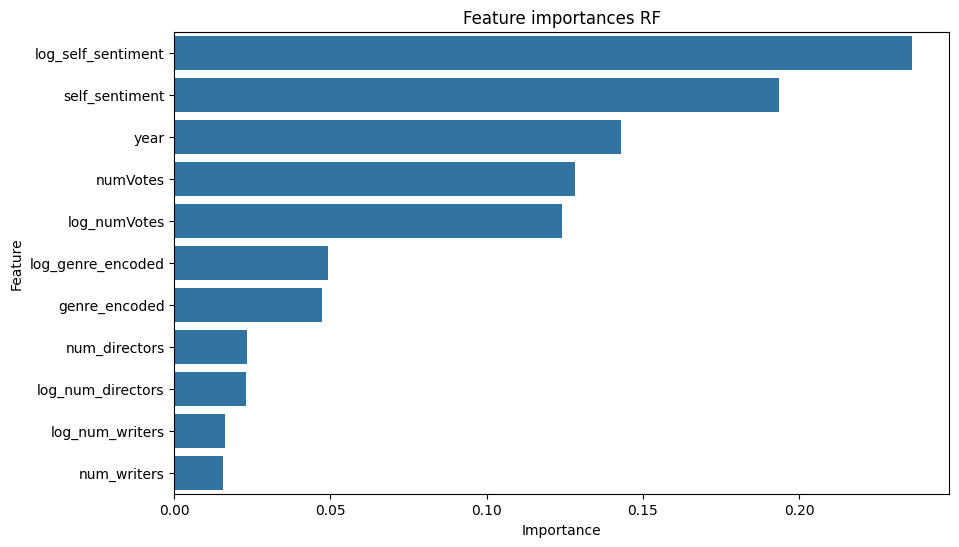

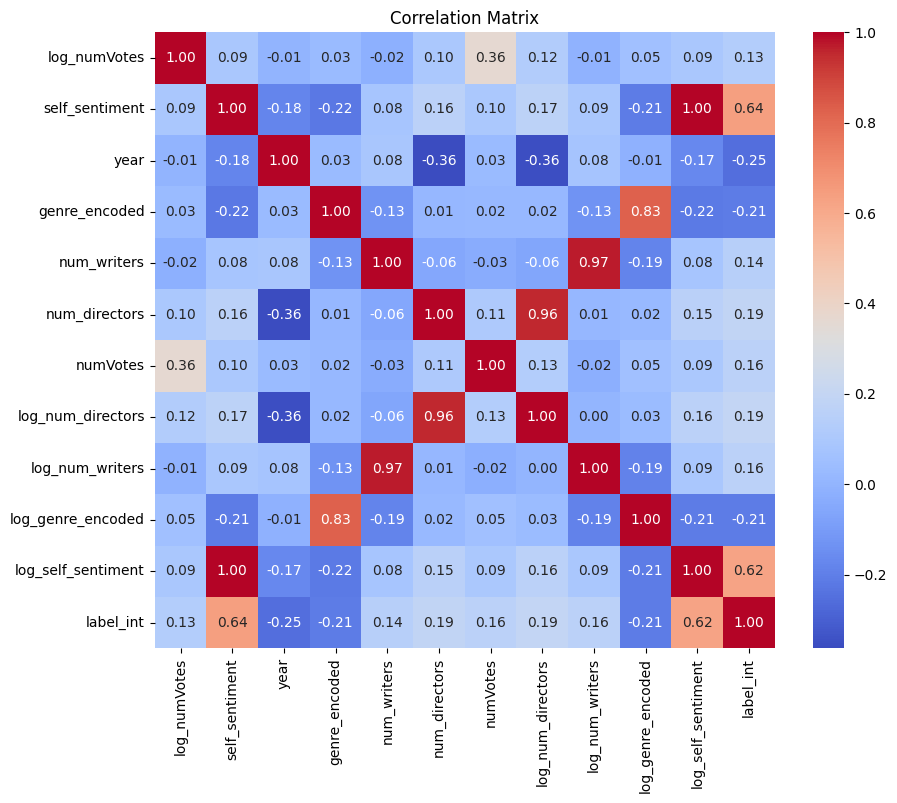

In [43]:
features = [
    'log_numVotes', 
    'self_sentiment', 
    'year', 
    'genre_encoded', 
    'num_writers', 
    'num_directors', 
    'numVotes', 
    'log_num_directors', 
    'log_num_writers',
    'log_genre_encoded',
    'log_self_sentiment',
    ]

# Define your target variable.
y = df['label_int']
X = df[features]

# Split the data for evaluation purposes.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit RFC.
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# feature importances from the model (traditional method)
importances = clf.feature_importances_
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("Feature Importances (from model):")
print(feature_importances)

# Plot feature importances.
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title("Feature importances RF")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# correlation matrix to inspect relationships.
corr_features = features + ['label_int']
corr_matrix = df[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [47]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

features = [
    'log_self_sentiment', 'self_sentiment', 'year', 'numVotes',
    'log_numVotes', 'genre_encoded', 'log_genre_encoded'
]

# Training data
X = df[features]
y = df['label_int']

# Hidden test and validation features
X_test_hidden = df_test_hidden[features]
X_validation_hidden = df_validation_hidden[features]

# parameter grids for each model
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

rfc_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

lgbm_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'subsample': [0.8, 0.9, 1.0]
}

models = {
    'XGBoost': (xgb.XGBClassifier(random_state=42), xgb_params),
    'RandomForest': (RandomForestClassifier(random_state=42), rfc_params),
    'LightGBM': (lgb.LGBMClassifier(random_state=42), lgbm_params)
}

In [48]:
# Dictionary to store evaluation metrics for each model
eval_results = {}

for model_name, (model_instance, param_grid) in models.items():
    print(f"\nTraining {model_name}...")
    
    # GridSearchCV
    grid_model = GridSearchCV(
        model_instance,
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    # cross-validation with multiple metrics
    cv_results = cross_validate(
        grid_model, X, y, cv=5,
        scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
        return_train_score=True
    )
    
    # Print CV results
    print(f"{model_name} Cross Validation results:")
    print(f"  Accuracy:  {cv_results['test_accuracy'].mean():.3f} ± {cv_results['test_accuracy'].std():.3f}")
    print(f"  Precision: {cv_results['test_precision'].mean():.3f} ± {cv_results['test_precision'].std():.3f}")
    print(f"  Recall:    {cv_results['test_recall'].mean():.3f} ± {cv_results['test_recall'].std():.3f}")
    print(f"  F1:        {cv_results['test_f1'].mean():.3f} ± {cv_results['test_f1'].std():.3f}")
    print(f"  ROC AUC:   {cv_results['test_roc_auc'].mean():.3f} ± {cv_results['test_roc_auc'].std():.3f}")
    
    eval_results[model_name] = {
        'Accuracy': cv_results['test_accuracy'].mean(),
        'Precision': cv_results['test_precision'].mean(),
        'Recall': cv_results['test_recall'].mean(),
        'F1': cv_results['test_f1'].mean(),
        'ROC AUC': cv_results['test_roc_auc'].mean()
    }
    
    # Fit the model on the full training data
    grid_model.fit(X, y)
    print(f"{model_name} best parameters:")
    print(grid_model.best_params_)
    
    # Make predictions on hidden test and validation sets
    test_hidden_preds = grid_model.predict(X_test_hidden)
    validation_hidden_preds = grid_model.predict(X_validation_hidden)
    
    # Convert numeric predictions to 'True'/'False' strings
    test_hidden_preds_str = ['True' if pred == 1 else 'False' for pred in test_hidden_preds]
    validation_hidden_preds_str = ['True' if pred == 1 else 'False' for pred in validation_hidden_preds]

    # store documents
    test_file = f'test_hidden_{model_name}_again.txt'
    validation_file = f'validation_hidden_{model_name}_again.txt'
    
    with open(test_file, 'w') as f:
        f.write('\n'.join(test_hidden_preds_str))
    with open(validation_file, 'w') as f:
        f.write('\n'.join(validation_hidden_preds_str))
    
    print(f"{model_name} predictions saved to text files")


Training XGBoost...
XGBoost Cross Validation results:
  Accuracy:  0.782 ± 0.044
  Precision: 0.745 ± 0.065
  Recall:    0.883 ± 0.067
  F1:        0.803 ± 0.022
  ROC AUC:   0.891 ± 0.009
XGBoost best parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
XGBoost predictions saved to text files

Training RandomForest...
RandomForest Cross Validation results:
  Accuracy:  0.741 ± 0.041
  Precision: 0.750 ± 0.086
  Recall:    0.776 ± 0.121
  F1:        0.749 ± 0.011
  ROC AUC:   0.864 ± 0.031


/var/folders/6f/_m3vtyy92m94t_l4qyl157240000gn/T/ipykernel_14753/2719401660.py:42: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


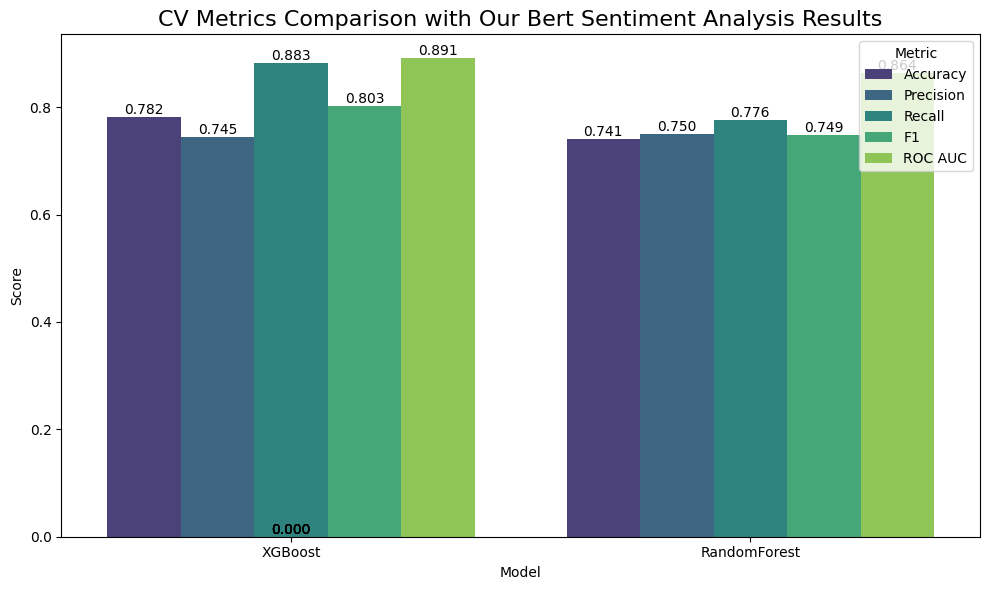

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# CV results as provided (mean values only)
cv_results = {
    'XGBoost': {
        'Accuracy': 0.782,
        'Precision': 0.745,
        'Recall': 0.883,
        'F1': 0.803,
        'ROC AUC': 0.891
    },
    'RandomForest': {
        'Accuracy': 0.741,
        'Precision': 0.750,
        'Recall': 0.776,
        'F1': 0.749,
        'ROC AUC': 0.864
    }
}

# Convert the dictionary into a DataFrame with columns: Model, Metric, Mean.
data = []
for model, metrics in cv_results.items():
    for metric, mean_val in metrics.items():
        data.append({"Model": model, "Metric": metric, "Mean": mean_val})
df_cv = pd.DataFrame(data)

# Define the desired order for models and metrics.
model_order = ['XGBoost', 'RandomForest']
metric_order = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']

df_cv['Model'] = pd.Categorical(df_cv['Model'], categories=model_order, ordered=True)
df_cv['Metric'] = pd.Categorical(df_cv['Metric'], categories=metric_order, ordered=True)

# Create a gradient palette using one of Seaborn's sequential color maps (e.g., viridis).
palette = sns.color_palette("viridis", n_colors=len(metric_order))

# Create a grouped bar plot.
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_cv,
    x='Model',
    y='Mean',
    hue='Metric',
    order=model_order,
    hue_order=metric_order,
    palette=palette,
    ci=None  # No error bars
)

# Add the actual value on top of each bar.
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2., 
        height, 
        f'{height:.3f}', 
        ha="center", 
        va="bottom", 
        fontsize=10, 
        color='black'
    )

# Customize the plot.
ax.set_title('CV Metrics Comparison with Our Bert Sentiment Analysis Results', fontsize=16)
ax.set_ylabel('Score')
ax.set_xlabel('Model')
plt.legend(title='Metric', loc='upper right')
plt.tight_layout()
plt.show()
